In [6]:
from torch.utils.data import DataLoader
from src.smalldiffusion import TimeInputMLP, ScheduleLogLinear, training_loop, samples
import numpy as np
import matplotlib.pyplot as plt
from animations import animate_diffusion
# This allows you to edit.g code in other files) without having to restart the kernel.
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def plot_batch(batch):
    batch = batch.cpu().numpy()
    plt.scatter(batch[:,0], batch[:,1], marker='.')

In [8]:
# Define the dataset to be used
# 100 instances and each instance is a 2D tensor
from src.smalldiffusion.data import FibonacciDataset


dataset  = FibonacciDataset(100) 
loader = DataLoader(dataset, batch_size=2048)

In [9]:
# input has 4 dimensions and output has 2 dimensions
model = TimeInputMLP(hidden_dims=(16,128,128,128,128,16))
print(model)


TimeInputMLP(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=16, out_features=128, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): GELU(approximate='none')
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): GELU(approximate='none')
    (10): Linear(in_features=128, out_features=16, bias=True)
    (11): GELU(approximate='none')
    (12): Linear(in_features=16, out_features=2, bias=True)
  )
)


<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_505470/2456428996.py:8: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sigma_t$')


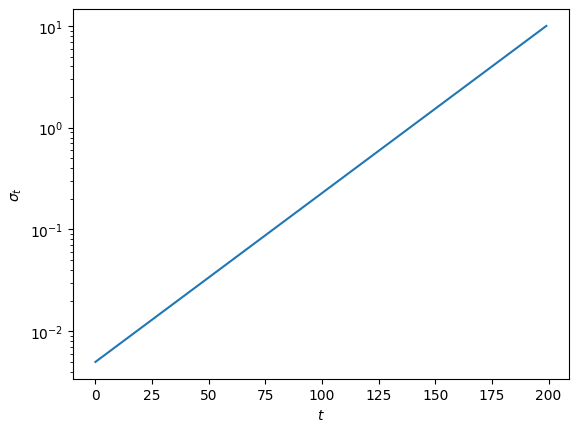

In [10]:
# the sigma values (or variance) in the context of diffusion models typically correspond to 
# the amount of noise added at each time step during the forward diffusion process.
# for this case, the lowest sigma (noise) is 0.005 and there are 200 sigma values
# that will gradually be added during the forward process
schedule = ScheduleLogLinear(N=200, sigma_min=0.005, sigma_max=10)
plt.plot(schedule.sigmas)
plt.xlabel('$t$')
plt.ylabel('$\sigma_t$')
plt.yscale('log')

<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\c'
<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_505470/2044932982.py:19: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(sx, label='$\sin(\log(\sigma_t)/2)$')
/tmp/ipykernel_505470/2044932982.py:20: SyntaxWarning: invalid escape sequence '\c'
  plt.plot(sy, label='$\cos(\log(\sigma_t)/2)$')


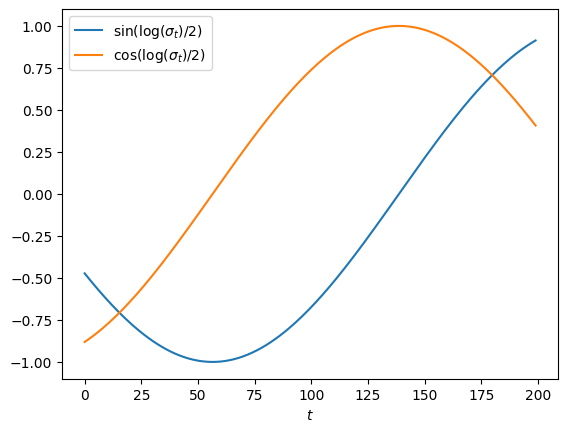

In [11]:
from src.smalldiffusion.model import get_sigma_embeds
"""
Sigma Embeddings
The sigma embeddings transform the sigma values into a form that the model can better utilize. 
This is done using sine and cosine functions of the logarithm of sigma. Here's why this is useful:

Purpose: The goal is to provide the model with a richer representation of the sigma value, 
         which represents the noise level. Instead of directly using sigma, which might 
         have a large dynamic range, the embeddings provide a bounded and periodic representation.

Transformation: By using sine and cosine of the logarithm of sigma, we capture both the scale (logarithm)
                and periodicity (sine and cosine) properties. This can help the model to learn more effectively, 
                especially when sigma varies widely.
"""

# schedule.sigmas is essentially 1D. however, get_sigma_embeds takes it to 2D
# where the first D is "torch.sin(torch.log(sigma)/2)" and the second D is "torch.cos(torch.log(sigma)/2)"
sx, sy = get_sigma_embeds(len(schedule), schedule.sigmas).T
plt.plot(sx, label='$\sin(\log(\sigma_t)/2)$')
plt.plot(sy, label='$\cos(\log(\sigma_t)/2)$')
plt.xlabel('$t$')
plt.legend()
plt.show()

In [12]:
trainer  = training_loop(loader, model, schedule, epochs=15000)
losses   = [ns.loss.item() for ns in trainer]

  0%|          | 0/15000 [00:00<?, ?it/s]


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [ ]:
# plot the loss
plt.plot(moving_average(losses, 100))
plt.show()

In [ ]:
# all the instances in the data combined (plotted) together results
# in this spiral shape. This is essentially the noiseless data that 
# represents the dataset
plot_batch(next(iter(loader)))

In [ ]:
# generate batchsize data points given that amount of initial noise
#   DDPM       : gam=1, mu=0.5
#   DDIM       : gam=1, mu=0
xt = samples(model, schedule.sample_sigmas(50), batchsize=1500, gam=2)

# convert it to a list
denoising_steps = list(xt)
plot_batch(denoising_steps[49])

In [ ]:
animate_diffusion(denoising_steps, filename="fibonacci", save=True)